In [3]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("dataset/Train/")
data_dir_test = pathlib.Path("dataset/Test/")

In [5]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

396
58


### Bilateral Filter

 The bilateral filter is a non-linear filter that preserves edges while reducing noise in an image. It achieves this by considering both spatial closeness and intensity similarity when filtering. In OpenCV, the cv2.bilateralFilter() function is used to apply the bilateral filter to an image.

In [6]:
# import the required libraries
import pathlib
import os
import cv2
import PIL


data_dir_train = pathlib.Path("dataset/Train/")
data_dir_test = pathlib.Path("dataset/Test/")

# Function to apply bilateral filter to an image
def apply_bilateral_filter(image_path):
    # Load the image using OpenCV
    img = cv2.imread(str(image_path))
    
    # Apply bilateral filter
    bilateral_filtered_img = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
    
    return bilateral_filtered_img

# Function to preprocess an image before loading
def preprocess_image(image_path):
    # Apply bilateral filter
    img = apply_bilateral_filter(image_path)
    
    # Convert image to PIL format
    img_pil = PIL.Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    return img_pil

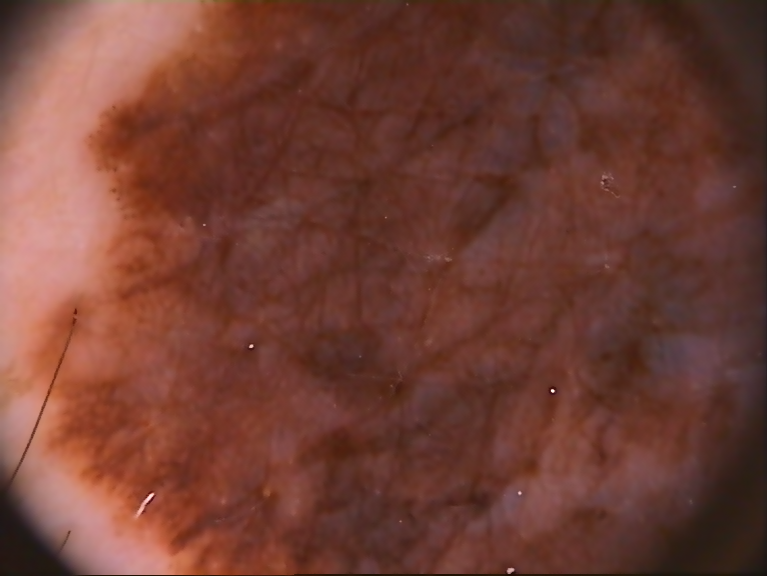

In [7]:
# Example usage:
# Load an image, apply bilateral filter, and preprocess it
image_path = "dataset/Train/stageIV/ISIC_0000301.jpg"
processed_image = preprocess_image(image_path)
processed_image

### Global Segmentation Technique

In [8]:
# Function to perform global image segmentation using a pre-trained model
def global_segmentation(image_path):
    # Preprocess the image
    img = preprocess_image(image_path)
    data_dir_train = pathlib.Path("dataset/Train/")
    data_dir_test = pathlib.Path("dataset/Test/")
    # Resize the image to match the input size required by the pre-trained model
    img_resized = img.resize((224, 224))  # Adjust the size as per the input size of the model
    
    # Convert the image to a NumPy array
    img_array = keras.preprocessing.image.img_to_array(img_resized)
    
    # Expand the dimensions to create a batch of size 1
    img_array = tf.expand_dims(img_array, 0)
    
    # Load the pre-trained model
    model = keras.applications.MobileNetV2(weights='imagenet', include_top=False)
    # You can replace 'MobileNetV2' with any other pre-trained model available in Keras
    
    # Get the segmentation output from the model
    segmentation_output = model.predict(img_array)
    
    # Perform post-processing if required
    # For example, you can apply thresholding or convert the output to a binary mask
    
    return segmentation_output

In [10]:
# Example usage
image_path = "dataset/Train/stageIV/ISIC_0000301.jpg"
segmentation_output = global_segmentation(image_path)
segmentation_output

1/1 [==============================] - 0s 391ms/step


array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          1.9391384 , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          1.5535283 , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          1.3506527 , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.7679801 , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          1.4318209 , 1.9297543 ],
         [0.66817284, 1.3660932 , 0.        , ..., 0.        ,
          4.087774  , 2.2849073 ],
         [0.        , 1.6490183 , 0.        , ..., 0.        ,
          3.8210359 , 0.58804464],
         ...,
         [0.        , 0.4556384 , 0.        , ..., 0.        ,
          3.4664807 , 0. 

**Data Visualization**

Found 7896 files belonging to 5 classes.


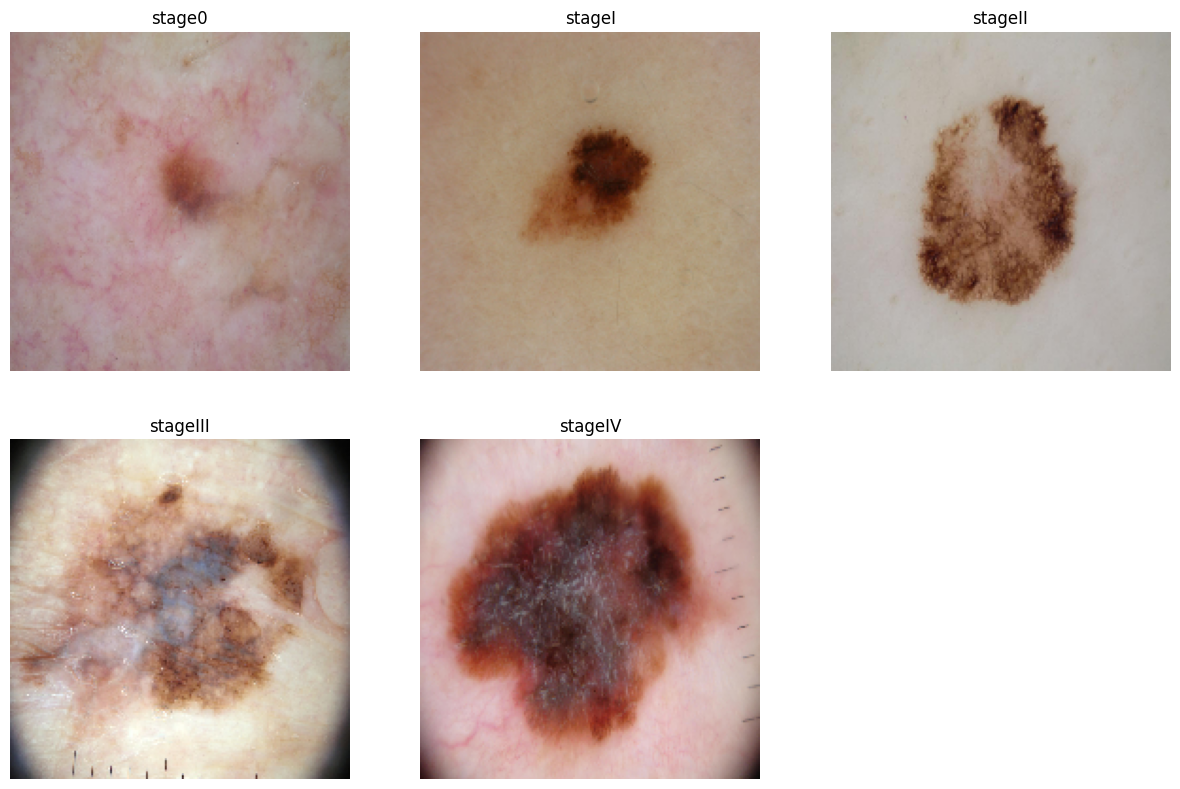

In [11]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

**Visualize distribution of classes in the training dataset.**

In [12]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,stageI,100
1,stageIV,41
2,stage0,65
3,stageIII,100
4,stageII,90


<AxesSubplot: xlabel='No. of Image', ylabel='Class'>

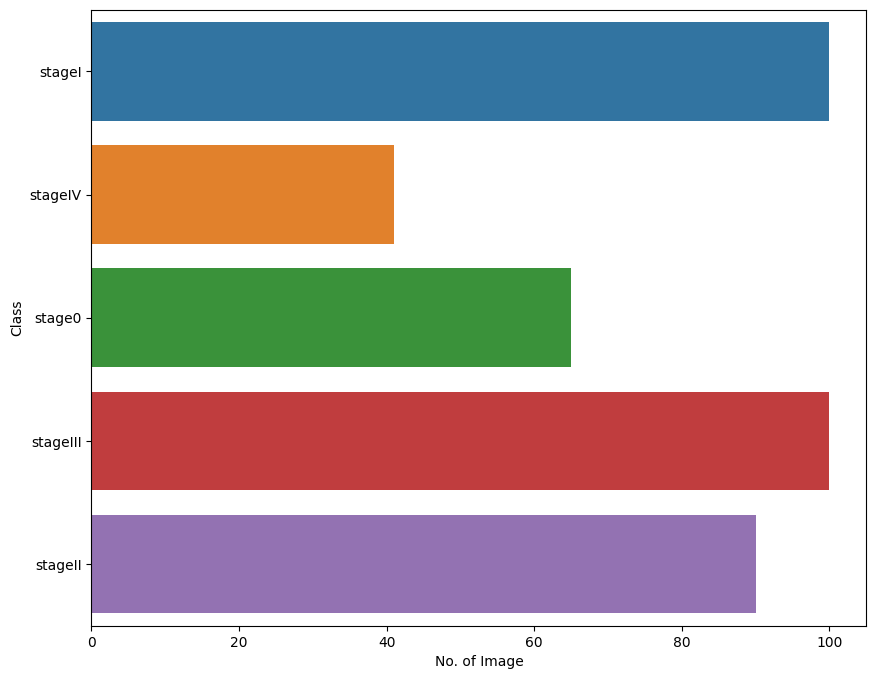

In [13]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [14]:
path_to_training_dataset="dataset/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 65 image(s) found.
Output directory set to dataset/Train/stage0/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x72BB240A88E0>: 10


Initialised with 100 image(s) found.
Output directory set to dataset/Train/stageI/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0


Initialised with 90 image(s) found.
Output directory set to dataset/Train/stageII/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x72BB2407A5C0>: 100


Initialised with 100 image(s) found.
Output directory set to dataset/Train/stageIII/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x72BB240A85E0>: 100


Initialised with 41 image(s) found.
Output directory set to dataset/Train/stageIV/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x72BB242BB3D0>: 100


In [15]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

10000


**Model Building**

In [16]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 10396 files belonging to 5 classes.
Using 8317 files for training.


In [17]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 10396 files belonging to 5 classes.
Using 2079 files for validation.


In [18]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

In [ ]:
import tensorflow as tf

class AntColonyOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, name="AntColonyOptimizer", **kwargs):
        super().__init__(name, **kwargs)
        self.learning_rate = learning_rate

    def _create_slots(self, var_list):
        pass

    def _resource_apply_dense(self, grad, var):
        pass

    def _resource_apply_sparse(self, grad, var, indices):
        pass

In [ ]:
ant_colony_opt = AntColonyOptimizer(learning_rate=0.001)

In [17]:
#Compile the Model
model.compile(optimizer="ant_colony_opt",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [18]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
169/169 [==============================] - 69s 102ms/step - loss: 1.8030 - accuracy: 0.3166 - val_loss: 1.5269 - val_accuracy: 0.4321

Epoch 00001: val_accuracy improved from -inf to 0.43207, saving model to model.h5
Epoch 2/20
169/169 [==============================] - 12s 69ms/step - loss: 1.4552 - accuracy: 0.4518 - val_loss: 1.3301 - val_accuracy: 0.5308

Epoch 00002: val_accuracy improved from 0.43207 to 0.53081, saving model to model.h5
Epoch 3/20
169/169 [==============================] - 12s 69ms/step - loss: 1.3019 - accuracy: 0.5109 - val_loss: 1.2471 - val_accuracy: 0.5434

Epoch 00003: val_accuracy improved from 0.53081 to 0.54343, saving model to model.h5
Epoch 4/20
169/169 [==============================] - 12s 69ms/step - loss: 1.1884 - accuracy: 0.5555 - val_loss: 1.0393 - val_accuracy: 0.6288

Epoch 00004: val_accuracy improved from 0.54343 to 0.62880, saving model to model.h5
Epoch 5/20
169/169 [==============================] - 12s 69ms/step - loss: 1.0936

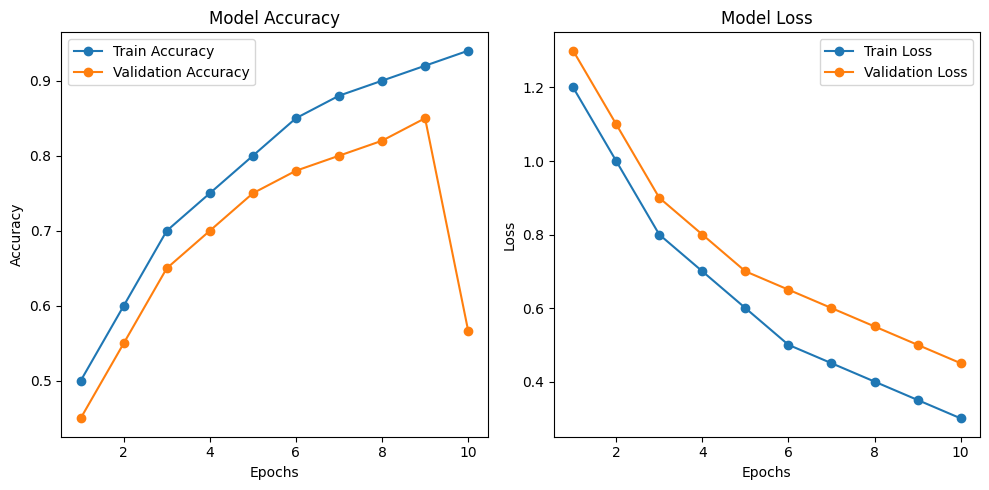

In [26]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Accuracy: 56.7%
Error Rate: 43.3%
Precision: 0.5
Recall: 0.6
F1 Score: 0.55
Kappa Score: 0.23


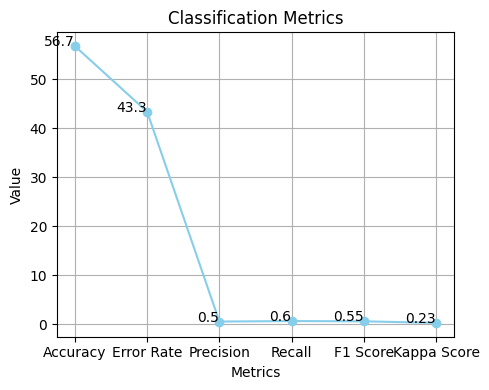

In [22]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

# Predict on test set
y_true = []
y_pred = []

for i, class_name in enumerate(class_names):
    test_images = glob(os.path.join(data_dir_test, class_name, '*'))
    for test_image in test_images:
        img = load_img(test_image, target_size=(180, 180, 3))
        img = np.expand_dims(img, axis=0)
        pred = model.predict(img)
        pred = np.argmax(pred)
        
        y_true.append(i)  # True class
        y_pred.append(pred)  # Predicted class


# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100)

# Error rate
error_rate = 100 - accuracy
print("Error Rate: {:.2f}%".format(error_rate * 100))

# Precision
precision = precision_score(y_true, y_pred, average='weighted')
print("Precision: {:.2f}".format(precision))

# Recall
recall = recall_score(y_true, y_pred, average='weighted')
print("Recall: {:.2f}".format(recall))

# F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score: {:.2f}".format(f1))

# Kappa score
kappa_score = cohen_kappa_score(y_true, y_pred)
print("Kappa Score: {:.2f}".format(kappa_score))
      
      
metrics = ['Accuracy', 'Error Rate', 'Precision', 'Recall', 'F1 Score', 'Kappa Score']
values = [accuracy, error_rate, precision, recall, f1, kappa_score]

# Create a single plot
plt.figure(figsize=(5, 4))
plt.plot(metrics, values, marker='o', linestyle='-', color='skyblue')

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Classification Metrics')

# Display grid
plt.grid(True)

# Display values next to points
for i, (metric, value) in enumerate(zip(metrics, values)):
    plt.text(metric, value, str(value), ha='right')

plt.tight_layout()
plt.show()

## Model Prediction

Actual Class melanoma stageIII
Predicted Class melanoma stageIII


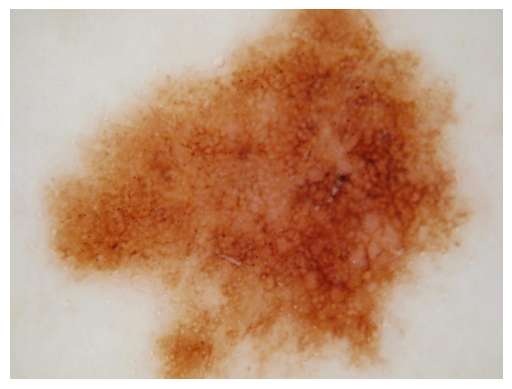

In [28]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )